## Imports

PRN -- 220940128008

Name -- Deshkar Saurabh

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [15]:
###-----------------
### Import Libraries
###-----------------
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [16]:
###---------------------------------------
### Global  parameters and Hyperparamaters
###---------------------------------------

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'dropout_bn_no_bias_leaky_flowers' # Model file name for this alternative

RANDOM_STATE = 108 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(seed = RANDOM_STATE)

tf.random.set_seed(RANDOM_STATE)

EPOCHS = 108   # number of cycles to run

ALPHA = 0.018

BATCH_SIZE = 32

TEST_SIZE = 0.36

IMG_HEIGHT = 188

IMG_WIDTH = 188

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 10 # if performace is not improving reduce alpha

LR_FACTOR = 0.5 # rate of reduction of alpha



# Matplotlib Params:: Setting before starting any plots

params = {'legend.fontsize': 18,
          'figure.figsize': (18, 18),
          'figure.titlesize' : 24,
          'axes.labelsize': 20,
          'axes.titlesize':22,
          'legend.title_fontsize' : 18,
          'grid.alpha' : 0.54,
          'grid.linestyle' : '--',
          'grid.linewidth' : 3,
          'xtick.labelsize':16,
          'ytick.labelsize':16,
          'font.size' : 18,
          'font.family' : 'serif',
          'lines.linewidth' : 2.7,
          
         }

CMAP = 'copper'

plt.rcParams.update(params) # update rcParams

In [ ]:
# Function to plot history

def fn_plot_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following columns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
    
    # create figure and axis array
    fig, axes = plt.subplots(1,2 , figsize = (18,9)) 

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='square', facecolor='cornflowerblue', alpha=0.45)

    
    # take first axis
    ax = axes[0]
    
    
    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], 
                 ax = ax,
                 colormap=CMAP) 

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()

    
    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.4, 0.95, txtstr,
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment='top',
            bbox=props)

    # x axis label
    ax.set_xlabel("Epochs")

    # y axis lable
    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    # Show grids on the axis
    ax.grid()
    
    
    # take second axis object
    ax = axes[1]

    # plot column 1 and 3 (accuracy and validation accuracy)
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]],
                 ax = ax, 
                 colormap=CMAP)

    
    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                          accmin,
                                                                          testmin) #text to plot
    
    # place a text box in upper left in axes coords
    ax.text(0.4, 0.5, txtstr, 
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment='top',
            bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [17]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [18]:
data_dir, os.listdir(data_dir)

('../input/flower_photos',
 ['sunflowers', 'LICENSE.txt', 'roses', 'daisy', 'dandelion', 'tulips'])

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [20]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


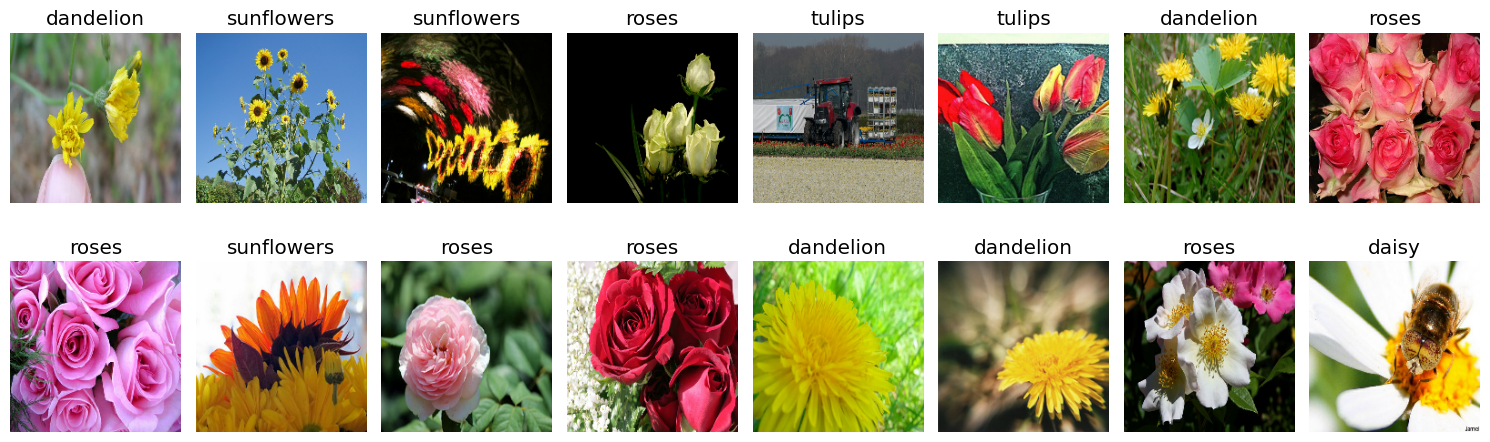

In [21]:
# set figure size
plt.figure(figsize=(15,5))

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        plt.subplot(int(BATCH_SIZE/8), 8, i+1 )
        
        # switch off the grids
        plt.grid(False)
        
        # image_size may have converted these images to float
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        plt.title(class_names[labels[i]])
        
        # no axis
        plt.axis("off")
        
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
# display all open images    
plt.show()

In [22]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(188, 188, 3)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
#def build_model(input_shape, n_classes):
model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1./255.))

##Data Augmentation Layers
model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, 
                                         fill_mode = 'nearest'))

model.add(tf.keras.layers.RandomFlip(mode = FLIP_MODE,
                                     seed= RANDOM_STATE ))

model.add(tf.keras.layers.RandomZoom(height_factor = (-0.2, -0.2), 
                                     width_factor= (-0.2, -0.2)))

#### CONVOLUTION LAYERS

kernel_init = tf.keras.initializers.GlorotNormal( seed = RANDOM_STATE)

#regular = tf.keras.regularizers.L2(l2=0.01)

##Convolution1
model.add(tf.keras.layers.Conv2D( 16, (5, 5),
                            kernel_initializer=kernel_init,
                            padding ='valid',
                            activation ='relu',
                            #kernel_regularizer=regular,
                            input_shape = ( IMG_HEIGHT, IMG_WIDTH, 1 ) ) ) ## 184 x 184

##Pool1
model.add(tf.keras.layers.MaxPool2D( (2, 2) ) ) ##92 x 92

##Convolution2
model.add(tf.keras.layers.Conv2D( 16, (5, 5),
                            kernel_initializer=kernel_init,
                            #kernel_regularizer=regular,
                            activation ='relu' ) ) ## 88 x 88

##Pool2
model.add(tf.keras.layers.MaxPool2D( (2, 2) ) ) ## 44 x 44

##Convolution3
model.add(tf.keras.layers.Conv2D( 16, (3, 3),
                            kernel_initializer=kernel_init,
                            #kernel_regularizer=regular,
                            activation ='relu' ) ) ## 42 x 42

##Convolution4
model.add(tf.keras.layers.Conv2D( 32, (3, 3),
                            kernel_initializer=kernel_init,
                            #kernel_regularizer=regular,
                            activation ='relu' ) ) ## 40 x 40

##Pool3
model.add(tf.keras.layers.MaxPool2D( (2, 2) ) ) ## 20 x 20

##Convolution5
model.add(tf.keras.layers.Conv2D( 32, (3, 3),
                            kernel_initializer=kernel_init,
                            #kernel_regularizer=regular,
                            activation ='relu' ) ) ## 18 x 18

##Convolution6
model.add(tf.keras.layers.Conv2D( 64, (3, 3),
                            kernel_initializer=kernel_init,
                            #kernel_regularizer=regular,
                            activation ='relu' ) ) ## 16 x 16

##Pool4
model.add(tf.keras.layers.MaxPool2D( (2, 2) ) ) ## 8 x 8

##Convolution7
model.add(tf.keras.layers.Conv2D( 64, (3, 3),
                            kernel_initializer=kernel_init,
                            #kernel_regularizer=regular,
                            activation ='relu' ) ) ## 6 x 6

#flatten layer
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(576,
                                kernel_initializer = kernel_init,
                                #kernel_regularizer=regular,
                                activation='relu'))

# Dense 2
model.add(tf.keras.layers.Dense(144,
                                kernel_initializer = kernel_init,
                                #kernel_regularizer=regular,
                                activation='relu'))


# Dense 3
model.add(tf.keras.layers.Dense(36,
                                kernel_initializer = kernel_init,
                                #kernel_regularizer=regular,
                                activation='relu'))

# Dense 4
model.add(tf.keras.layers.Dense(9,
                                kernel_initializer = kernel_init,
                                #kernel_regularizer=regular,
                                activation='relu'))
# Output layer
model.add(tf.keras.layers.Dense(5))

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_ds)

Epoch 1/100
184/184 [==============================] - 31s 145ms/step - loss: 1.5840 - accuracy: 0.2572 - val_loss: 1.6083 - val_accuracy: 0.1880
Epoch 2/100
184/184 [==============================] - 26s 144ms/step - loss: 1.6057 - accuracy: 0.2228 - val_loss: 1.6048 - val_accuracy: 0.2384
Epoch 3/100
184/184 [==============================] - 26s 144ms/step - loss: 1.6028 - accuracy: 0.2463 - val_loss: 1.6031 - val_accuracy: 0.2384
Epoch 4/100
184/184 [==============================] - 26s 144ms/step - loss: 1.6013 - accuracy: 0.2463 - val_loss: 1.6023 - val_accuracy: 0.2384
Epoch 5/100
184/184 [==============================] - 26s 143ms/step - loss: 1.6006 - accuracy: 0.2463 - val_loss: 1.6020 - val_accuracy: 0.2384
Epoch 6/100
 63/184 [=========>....................] - ETA: 16s - loss: 1.6009 - accuracy: 0.2460

KeyboardInterrupt: 